In [335]:
import pandas as pd
import geopandas as gpd
import json 
from shapely.geometry import shape, Point
import shapely

import numpy as np

import matplotlib.pyplot as plt
import plotly.express as px
import folium

from vincenty import vincenty

import requests
import urllib.parse
import re

from sklearn import preprocessing


# Option d'affchage
pd.set_option('display.max_columns', None)

In [336]:
df0 = pd.read_csv('data/données_calculees0.csv', index_col = 0)
df = df0.copy()

In [337]:
df = df[df['score_jardin'] != max(df['score_jardin'])]

In [338]:
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

In [339]:
min_max_scaler = preprocessing.MinMaxScaler()
df[[
    'Numero', 'NbPieces', 'lon', 'lat', 
    'periode_construction', 'Arrondissement', 'Quartier',
    'prixm2', 'score_commerce', 'score_commerce_lux','score_monument', 
    'score_jardin', 'score_metro'
    ]] = min_max_scaler.fit_transform(df[[
                        'Numero', 'NbPieces', 'lon', 'lat', 
                        'periode_construction', 'Arrondissement', 'Quartier',
                        'prixm2', 'score_commerce', 'score_commerce_lux','score_monument', 
                        'score_jardin', 'score_metro'
                                        ]])

In [340]:
df['TypeVoie']=df['TypeVoie'].astype(str)
le= LabelEncoder()
 
df['TypeVoie_encoded'] = le.fit_transform(df.TypeVoie)
ohe = OneHotEncoder()
 
X = ohe.fit_transform(df.TypeVoie_encoded.values.reshape(-1,1)).toarray()
 
dfOneHot = pd.DataFrame(X, columns = ["TypeVoie_"+str(int(i)) for i in range(X.shape[1])])
df = pd.concat([df, dfOneHot], axis=1).drop(columns = ['TypeVoie', 'TypeVoie_encoded']).dropna()

# Regressions linéaires et polynomiales

### Regression linéaire

In [341]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error

In [343]:
y = df[['prixm2']]
X = df.drop(columns = ['prixm2'])
lin_reg = LinearRegression().fit(X, y)
y_pred = lin_reg.predict(X)

In [344]:
pd.DataFrame([(X.columns[i], lin_reg.coef_[0][i]) for i in range(28)]).T.rename(index = {0 : 'variable', 1 : 'coeff'})

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27
variable,Numero,NbPieces,lon,lat,score_commerce,score_commerce_lux,periode_construction,Arrondissement,Quartier,score_jardin,score_monument,score_metro,TypeVoie_0,TypeVoie_1,TypeVoie_2,TypeVoie_3,TypeVoie_4,TypeVoie_5,TypeVoie_6,TypeVoie_7,TypeVoie_8,TypeVoie_9,TypeVoie_10,TypeVoie_11,TypeVoie_12,TypeVoie_13,TypeVoie_14,TypeVoie_15
coeff,-0.0275651,0.0314309,-0.0130585,-0.0183923,-0.0773825,0.0748013,0.00415293,0.00482153,-0.0588076,0.188505,0.128844,-0.0254476,2.37405e+12,2.37405e+12,2.37405e+12,2.37405e+12,2.37405e+12,2.37405e+12,2.37405e+12,2.37405e+12,2.37405e+12,2.37405e+12,2.37405e+12,2.37405e+12,2.37405e+12,2.37405e+12,2.37405e+12,2.37405e+12


In [345]:
mean_squared_error(y, y_pred)

0.01535874251364906

### Regressions polynomiales

In [346]:
def polyreg(n):
    poly_X = X.copy()
    
    for i in range(2, n+1):
        index = [str(j) + '^' + str(i) for j in X.columns[:12]]
        
        poly_X[[str(j) + '^' + str(i) for j in X.columns[:12]]] = poly_X[[j for j in X.columns[:12]]].pow(i)
    
    poly_reg = LinearRegression().fit(poly_X, y)
    y_pred = poly_reg.predict(poly_X)
    MSE = mean_squared_error(y, y_pred)
    
    
    display(pd.DataFrame([(poly_X.columns[i], poly_reg.coef_[0][i]) for i in range(28 + 12 * (n - 1))]).T.rename(index = {0 : 'variable', 1 : 'coeff'}).T.sort_values(by = 'variable').T)
    #print('MSE : ', MSE)
    return MSE
    

In [347]:
polyreg(5)

,7,35,47,59,71,1,29,41,53,65,0,28,40,52,64,8,36,48,60,72,12,13,22,23,24,25,26,27,14,15,16,17,18,19,20,21,3,31,43,55,67,2,30,42,54,66,6,34,46,58,70,4,32,44,56,68,5,33,45,57,69,9,37,49,61,73,11,39,51,63,75,10,38,50,62,74
variable,Arrondissement,Arrondissement^2,Arrondissement^3,Arrondissement^4,Arrondissement^5,NbPieces,NbPieces^2,NbPieces^3,NbPieces^4,NbPieces^5,Numero,Numero^2,Numero^3,Numero^4,Numero^5,Quartier,Quartier^2,Quartier^3,Quartier^4,Quartier^5,TypeVoie_0,TypeVoie_1,TypeVoie_10,TypeVoie_11,TypeVoie_12,TypeVoie_13,TypeVoie_14,TypeVoie_15,TypeVoie_2,TypeVoie_3,TypeVoie_4,TypeVoie_5,TypeVoie_6,TypeVoie_7,TypeVoie_8,TypeVoie_9,lat,lat^2,lat^3,lat^4,lat^5,lon,lon^2,lon^3,lon^4,lon^5,periode_construction,periode_construction^2,periode_construction^3,periode_construction^4,periode_construction^5,score_commerce,score_commerce^2,score_commerce^3,score_commerce^4,score_commerce^5,score_commerce_lux,score_commerce_lux^2,score_commerce_lux^3,score_commerce_lux^4,score_commerce_lux^5,score_jardin,score_jardin^2,score_jardin^3,score_jardin^4,score_jardin^5,score_metro,score_metro^2,score_metro^3,score_metro^4,score_metro^5,score_monument,score_monument^2,score_monument^3,score_monument^4,score_monument^5
coeff,0.982966,-7.68487,18.4544,-17.0562,5.33512,-1.39422,10.0114,-30.6576,42.982,-21.1813,0.0967966,-0.834359,2.23128,-2.59566,1.08333,-0.405052,7.38355,-23.9809,27.9621,-11.039,0.0118118,0.0249284,0.023172,0.00852516,0.00689923,-0.011118,-0.00825339,-0.0153538,0.0039335,-0.00832765,0.00387521,-0.0151815,-0.0406537,0.00273685,-0.00408209,0.017088,0.381503,-3.87547,11.9726,-14.7906,6.32403,-1.38,8.02904,-19.0049,19.5945,-7.25776,0.236015,-1.95219,6.19114,-7.99148,3.56287,-0.133832,-0.973362,5.00658,-7.76287,3.86259,0.489581,-2.63408,7.28138,-9.13998,4.0968,0.0460013,8.93104,-43.4424,61.9468,-27.5631,0.58864,-4.50698,12.4483,-14.2317,5.73903,0.114396,0.9191,-3.2952,3.82983,-1.36467


0.014935190319499402

,7,35,1,29,0,28,8,36,12,13,22,23,24,25,26,27,14,15,16,17,18,19,20,21,3,31,2,30,6,34,4,32,5,33,9,37,11,39,10,38
variable,Arrondissement,Arrondissement^2,NbPieces,NbPieces^2,Numero,Numero^2,Quartier,Quartier^2,TypeVoie_0,TypeVoie_1,TypeVoie_10,TypeVoie_11,TypeVoie_12,TypeVoie_13,TypeVoie_14,TypeVoie_15,TypeVoie_2,TypeVoie_3,TypeVoie_4,TypeVoie_5,TypeVoie_6,TypeVoie_7,TypeVoie_8,TypeVoie_9,lat,lat^2,lon,lon^2,periode_construction,periode_construction^2,score_commerce,score_commerce^2,score_commerce_lux,score_commerce_lux^2,score_jardin,score_jardin^2,score_metro,score_metro^2,score_monument,score_monument^2
coeff,0.0837001,0.00254632,-0.256729,0.706371,-0.00904485,-0.0343342,-0.0267192,-0.110442,0.0122768,0.0260606,0.0158465,0.00904241,0.000209673,-0.0123201,-0.00806461,-0.0363718,0.00528111,0.0376711,-0.00118093,-0.0209183,-0.0416228,0.000364543,-0.00429217,0.0180181,-0.0022124,0.0010665,-0.0172491,0.0134463,0.0234783,-0.0186662,-0.253217,0.210069,0.205904,-0.152625,0.259144,-0.343963,-0.086478,0.0643048,0.0738097,0.0720658


,7,35,47,1,29,41,0,28,40,8,36,48,12,13,22,23,24,25,26,27,14,15,16,17,18,19,20,21,3,31,43,2,30,42,6,34,46,4,32,44,5,33,45,9,37,49,11,39,51,10,38,50
variable,Arrondissement,Arrondissement^2,Arrondissement^3,NbPieces,NbPieces^2,NbPieces^3,Numero,Numero^2,Numero^3,Quartier,Quartier^2,Quartier^3,TypeVoie_0,TypeVoie_1,TypeVoie_10,TypeVoie_11,TypeVoie_12,TypeVoie_13,TypeVoie_14,TypeVoie_15,TypeVoie_2,TypeVoie_3,TypeVoie_4,TypeVoie_5,TypeVoie_6,TypeVoie_7,TypeVoie_8,TypeVoie_9,lat,lat^2,lat^3,lon,lon^2,lon^3,periode_construction,periode_construction^2,periode_construction^3,score_commerce,score_commerce^2,score_commerce^3,score_commerce_lux,score_commerce_lux^2,score_commerce_lux^3,score_jardin,score_jardin^2,score_jardin^3,score_metro,score_metro^2,score_metro^3,score_monument,score_monument^2,score_monument^3
coeff,-0.236698,0.813273,-0.51137,-0.625875,2.38246,-2.0039,0.0175962,-0.142282,0.0970959,0.663406,-1.8547,1.1475,2.82554e+12,2.82554e+12,2.82554e+12,2.82554e+12,2.82554e+12,2.82554e+12,2.82554e+12,2.82554e+12,2.82554e+12,2.82554e+12,2.82554e+12,2.82554e+12,2.82554e+12,2.82554e+12,2.82554e+12,2.82554e+12,-0.0311335,-0.041353,0.0607852,0.00132804,-0.00501495,-0.0289838,-0.0308998,0.0925006,-0.0657896,-0.286621,0.278464,-0.0541445,0.265042,-0.307629,0.112684,0.268948,-0.257825,0.0714452,-0.0110681,-0.0930256,0.0903901,0.169074,-0.20009,0.184908


,7,35,47,59,1,29,41,53,0,28,40,52,8,36,48,60,12,13,22,23,24,25,26,27,14,15,16,17,18,19,20,21,3,31,43,55,2,30,42,54,6,34,46,58,4,32,44,56,5,33,45,57,9,37,49,61,11,39,51,63,10,38,50,62
variable,Arrondissement,Arrondissement^2,Arrondissement^3,Arrondissement^4,NbPieces,NbPieces^2,NbPieces^3,NbPieces^4,Numero,Numero^2,Numero^3,Numero^4,Quartier,Quartier^2,Quartier^3,Quartier^4,TypeVoie_0,TypeVoie_1,TypeVoie_10,TypeVoie_11,TypeVoie_12,TypeVoie_13,TypeVoie_14,TypeVoie_15,TypeVoie_2,TypeVoie_3,TypeVoie_4,TypeVoie_5,TypeVoie_6,TypeVoie_7,TypeVoie_8,TypeVoie_9,lat,lat^2,lat^3,lat^4,lon,lon^2,lon^3,lon^4,periode_construction,periode_construction^2,periode_construction^3,periode_construction^4,score_commerce,score_commerce^2,score_commerce^3,score_commerce^4,score_commerce_lux,score_commerce_lux^2,score_commerce_lux^3,score_commerce_lux^4,score_jardin,score_jardin^2,score_jardin^3,score_jardin^4,score_metro,score_metro^2,score_metro^3,score_metro^4,score_monument,score_monument^2,score_monument^3,score_monument^4
coeff,0.234746,-1.65244,3.16405,-1.69394,-0.848588,4.28326,-6.81067,3.18146,0.0566045,-0.390952,0.619271,-0.31794,1.06214,-3.27083,3.63475,-1.47365,0.0162841,0.0287264,0.019949,0.0117201,0.00558184,-0.00792707,-0.00558281,-0.0283238,0.00668018,-0.0156334,0.00681482,-0.0145915,-0.0458658,0.00337955,-0.000851337,0.0196397,-0.0224719,0.101465,-0.062404,-0.0540427,-0.175631,1.02844,-1.82436,1.01579,-0.0304138,0.237792,-0.382872,0.17805,-0.283837,0.402229,-0.242657,0.0634678,0.370846,-1.15495,1.66909,-0.808966,-0.0168784,7.93726,-29.3769,21.382,0.0875588,-0.561105,0.896655,-0.43243,0.0848857,0.130644,-0.464326,0.435387


,7,35,47,59,71,1,29,41,53,65,0,28,40,52,64,8,36,48,60,72,12,13,22,23,24,25,26,27,14,15,16,17,18,19,20,21,3,31,43,55,67,2,30,42,54,66,6,34,46,58,70,4,32,44,56,68,5,33,45,57,69,9,37,49,61,73,11,39,51,63,75,10,38,50,62,74
variable,Arrondissement,Arrondissement^2,Arrondissement^3,Arrondissement^4,Arrondissement^5,NbPieces,NbPieces^2,NbPieces^3,NbPieces^4,NbPieces^5,Numero,Numero^2,Numero^3,Numero^4,Numero^5,Quartier,Quartier^2,Quartier^3,Quartier^4,Quartier^5,TypeVoie_0,TypeVoie_1,TypeVoie_10,TypeVoie_11,TypeVoie_12,TypeVoie_13,TypeVoie_14,TypeVoie_15,TypeVoie_2,TypeVoie_3,TypeVoie_4,TypeVoie_5,TypeVoie_6,TypeVoie_7,TypeVoie_8,TypeVoie_9,lat,lat^2,lat^3,lat^4,lat^5,lon,lon^2,lon^3,lon^4,lon^5,periode_construction,periode_construction^2,periode_construction^3,periode_construction^4,periode_construction^5,score_commerce,score_commerce^2,score_commerce^3,score_commerce^4,score_commerce^5,score_commerce_lux,score_commerce_lux^2,score_commerce_lux^3,score_commerce_lux^4,score_commerce_lux^5,score_jardin,score_jardin^2,score_jardin^3,score_jardin^4,score_jardin^5,score_metro,score_metro^2,score_metro^3,score_metro^4,score_metro^5,score_monument,score_monument^2,score_monument^3,score_monument^4,score_monument^5
coeff,0.982966,-7.68487,18.4544,-17.0562,5.33512,-1.39422,10.0114,-30.6576,42.982,-21.1813,0.0967966,-0.834359,2.23128,-2.59566,1.08333,-0.405052,7.38355,-23.9809,27.9621,-11.039,0.0118118,0.0249284,0.023172,0.00852516,0.00689923,-0.011118,-0.00825339,-0.0153538,0.0039335,-0.00832765,0.00387521,-0.0151815,-0.0406537,0.00273685,-0.00408209,0.017088,0.381503,-3.87547,11.9726,-14.7906,6.32403,-1.38,8.02904,-19.0049,19.5945,-7.25776,0.236015,-1.95219,6.19114,-7.99148,3.56287,-0.133832,-0.973362,5.00658,-7.76287,3.86259,0.489581,-2.63408,7.28138,-9.13998,4.0968,0.0460013,8.93104,-43.4424,61.9468,-27.5631,0.58864,-4.50698,12.4483,-14.2317,5.73903,0.114396,0.9191,-3.2952,3.82983,-1.36467


,7,35,47,59,71,83,1,29,41,53,65,77,0,28,40,52,64,76,8,36,48,60,72,84,12,13,22,23,24,25,26,27,14,15,16,17,18,19,20,21,3,31,43,55,67,79,2,30,42,54,66,78,6,34,46,58,70,82,4,32,44,56,68,80,5,33,45,57,69,81,9,37,49,61,73,85,11,39,51,63,75,87,10,38,50,62,74,86
variable,Arrondissement,Arrondissement^2,Arrondissement^3,Arrondissement^4,Arrondissement^5,Arrondissement^6,NbPieces,NbPieces^2,NbPieces^3,NbPieces^4,NbPieces^5,NbPieces^6,Numero,Numero^2,Numero^3,Numero^4,Numero^5,Numero^6,Quartier,Quartier^2,Quartier^3,Quartier^4,Quartier^5,Quartier^6,TypeVoie_0,TypeVoie_1,TypeVoie_10,TypeVoie_11,TypeVoie_12,TypeVoie_13,TypeVoie_14,TypeVoie_15,TypeVoie_2,TypeVoie_3,TypeVoie_4,TypeVoie_5,TypeVoie_6,TypeVoie_7,TypeVoie_8,TypeVoie_9,lat,lat^2,lat^3,lat^4,lat^5,lat^6,lon,lon^2,lon^3,lon^4,lon^5,lon^6,periode_construction,periode_construction^2,periode_construction^3,periode_construction^4,periode_construction^5,periode_construction^6,score_commerce,score_commerce^2,score_commerce^3,score_commerce^4,score_commerce^5,score_commerce^6,score_commerce_lux,score_commerce_lux^2,score_commerce_lux^3,score_commerce_lux^4,score_commerce_lux^5,score_commerce_lux^6,score_jardin,score_jardin^2,score_jardin^3,score_jardin^4,score_jardin^5,score_jardin^6,score_metro,score_metro^2,score_metro^3,score_metro^4,score_metro^5,score_metro^6,score_monument,score_monument^2,score_monument^3,score_monument^4,score_monument^5,score_monument^6
coeff,0.65461,-10.9269,38.8765,-59.6723,43.6987,-12.6617,-1.66459,13.6953,-52.3124,102.183,-94.6963,32.5494,0.15852,-1.68867,7.00682,-14.4876,14.3828,-5.42437,-2.39702,34.9367,-142.132,252.715,-208.012,64.8271,0.0142783,0.0246569,0.0231002,0.00767518,0.00482676,-0.0302933,-0.00231712,-0.00304807,0.00437053,-0.0210262,0.00629201,-0.0143357,-0.0269587,-0.000471449,-0.00472509,0.0179757,3.34177,-28.2419,100.139,-171.267,140.409,-44.3506,0.369484,-8.03331,42.6081,-93.7368,92.3437,-33.5752,-0.429416,6.19176,-31.2639,70.4491,-71.9377,27.0979,-0.125642,-1.06531,5.26919,-7.70837,3.24204,0.388879,0.557816,-4.28389,17.2621,-34.1292,31.5581,-10.8938,-0.690141,57.8577,-770.332,3487.2,-6122.33,3348.21,0.498283,-3.64348,9.97417,-11.2709,4.32391,0.160111,0.163559,-0.526804,3.47747,-8.73992,8.87796,-3.08135


,7,35,47,59,71,83,95,1,29,41,53,65,77,89,0,28,40,52,64,76,88,8,36,48,60,72,84,96,12,13,22,23,24,25,26,27,14,15,16,17,18,19,20,21,3,31,43,55,67,79,91,2,30,42,54,66,78,90,6,34,46,58,70,82,94,4,32,44,56,68,80,92,5,33,45,57,69,81,93,9,37,49,61,73,85,97,11,39,51,63,75,87,99,10,38,50,62,74,86,98
variable,Arrondissement,Arrondissement^2,Arrondissement^3,Arrondissement^4,Arrondissement^5,Arrondissement^6,Arrondissement^7,NbPieces,NbPieces^2,NbPieces^3,NbPieces^4,NbPieces^5,NbPieces^6,NbPieces^7,Numero,Numero^2,Numero^3,Numero^4,Numero^5,Numero^6,Numero^7,Quartier,Quartier^2,Quartier^3,Quartier^4,Quartier^5,Quartier^6,Quartier^7,TypeVoie_0,TypeVoie_1,TypeVoie_10,TypeVoie_11,TypeVoie_12,TypeVoie_13,TypeVoie_14,TypeVoie_15,TypeVoie_2,TypeVoie_3,TypeVoie_4,TypeVoie_5,TypeVoie_6,TypeVoie_7,TypeVoie_8,TypeVoie_9,lat,lat^2,lat^3,lat^4,lat^5,lat^6,lat^7,lon,lon^2,lon^3,lon^4,lon^5,lon^6,lon^7,periode_construction,periode_construction^2,periode_construction^3,periode_construction^4,periode_construction^5,periode_construction^6,periode_construction^7,score_commerce,score_commerce^2,score_commerce^3,score_commerce^4,score_commerce^5,score_commerce^6,score_commerce^7,score_commerce_lux,score_commerce_lux^2,score_commerce_lux^3,score_commerce_lux^4,score_commerce_lux^5,score_commerce_lux^6,score_commerce_lux^7,score_jardin,score_jardin^2,score_jardin^3,score_jardin^4,score_jardin^5,score_jardin^6,score_jardin^7,score_metro,score_metro^2,score_metro^3,score_metro^4,score_metro^5,score_metro^6,score_metro^7,score_monument,score_monument^2,score_monument^3,score_monument^4,score_monument^5,score_monument^6,score_monument^7
coeff,0.945395,-9.01963,18.4635,3.58211,-45.5218,46.8292,-15.2305,0.109469,-16.362,188.032,-892.833,2062.63,-2250.46,908.685,0.379057,-6.08782,39.8699,-128.455,212.183,-171.887,54.0044,-1.28292,12.8343,-6.95009,-127.757,335.303,-318.217,105.948,0.0116527,0.0213703,0.0216844,0.00465513,0.00300628,-0.0356504,-0.00495649,-0.000867761,0.00193163,0.0160834,0.00317903,-0.0169077,-0.0272369,-0.00458143,-0.00745484,0.0140946,3.623,-30.2393,106.426,-181.144,147.753,-46.2468,-0.160664,-0.327781,0.721861,-2.3933,22.7696,-67.0789,76.4703,-30.1954,-0.203584,2.30693,-6.91394,-2.33841,39.8858,-58.0249,25.4053,0.277782,-8.6225,59.8078,-192.601,317.236,-257.263,81.181,0.754393,-8.49387,50.5455,-156.015,253.334,-204.819,64.7566,-1.65936,130.707,-2260.53,15126.2,-46138.1,63145.1,-30001.8,0.249618,-0.560853,-8.17738,41.5495,-74.4768,58.1335,-16.6914,0.651587,-7.70324,45.9785,-133.574,200.443,-149.769,44.1761


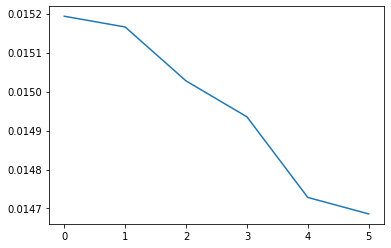

In [348]:
plt.plot([polyreg(i) for i in range(2, 8)])

### Regression pénalisée

In [354]:
from sklearn.linear_model import ElasticNet

In [433]:
EN_reg = ElasticNet(alpha=.1, copy_X=True, fit_intercept=False, l1_ratio=.05,
           max_iter=1000, normalize=False, positive=False, precompute=False,
           random_state=2, selection='cyclic', tol=0.0001, warm_start=False)
EN_reg.fit(X, y)

ElasticNet(alpha=0.1, copy_X=True, fit_intercept=False, l1_ratio=0.05,
           max_iter=1000, normalize=False, positive=False, precompute=False,
           random_state=2, selection='cyclic', tol=0.0001, warm_start=False)

In [434]:
pd.DataFrame([(X.columns[i], EN_reg.coef_[i]) for i in range(28)]).T.rename(index = {0 : 'variable', 1 : 'coeff'})

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27
variable,Numero,NbPieces,lon,lat,score_commerce,score_commerce_lux,periode_construction,Arrondissement,Quartier,score_jardin,score_monument,score_metro,TypeVoie_0,TypeVoie_1,TypeVoie_2,TypeVoie_3,TypeVoie_4,TypeVoie_5,TypeVoie_6,TypeVoie_7,TypeVoie_8,TypeVoie_9,TypeVoie_10,TypeVoie_11,TypeVoie_12,TypeVoie_13,TypeVoie_14,TypeVoie_15
coeff,0,0,0.0469752,0.0348265,0,0.00570882,0.0254697,0.0357126,0.037531,0,0.114961,0,0,0.0183243,0.0031899,0,0,0,0,0,0,0,0,0.0677917,0,0,0,0


In [436]:
#y_pred = EN_reg.predict(X)
#mean_squared_error(y, y_pred)

### Réseau de neurones

In [452]:
#from sklearn.model_selection import train_test_split
#X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.2)

In [497]:
import keras
from keras.models import Sequential
from keras.layers import Dense

In [593]:
model = Sequential()
model.add(Dense(28, input_dim = 28, activation='relu'))
model.add(Dense(1))



In [594]:
model.compile(optimizer='adam', loss='mse', metrics=['mse'])

In [595]:
history = model.fit(X, y, validation_split = 0.2,  epochs = 20)

Train on 19972 samples, validate on 4993 samples
Epoch 1/20
19972/19972 [==============================] - 1s 74us/step - loss: 0.0267 - mse: 0.0267 - val_loss: 0.0127 - val_mse: 0.0127
Epoch 2/20
19972/19972 [==============================] - 1s 70us/step - loss: 0.0164 - mse: 0.0164 - val_loss: 0.0124 - val_mse: 0.0124
Epoch 3/20
19972/19972 [==============================] - 1s 70us/step - loss: 0.0161 - mse: 0.0161 - val_loss: 0.0121 - val_mse: 0.0121
Epoch 4/20
19972/19972 [==============================] - 1s 64us/step - loss: 0.0159 - mse: 0.0159 - val_loss: 0.0124 - val_mse: 0.0124
Epoch 5/20
19972/19972 [==============================] - 1s 67us/step - loss: 0.0158 - mse: 0.0158 - val_loss: 0.0123 - val_mse: 0.0123
Epoch 6/20
19972/19972 [==============================] - 1s 72us/step - loss: 0.0157 - mse: 0.0157 - val_loss: 0.0129 - val_mse: 0.0129
Epoch 7/20
19972/19972 [==============================] - 1s 75us/step - loss: 0.0156 - mse: 0.0156 - val_loss: 0.0122 - val_mse:

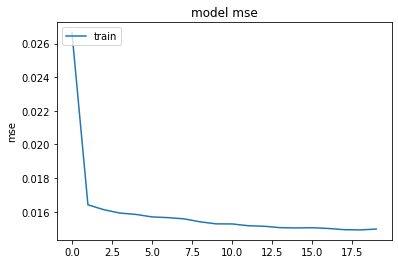

In [596]:
plt.plot(history.history['mse'])
plt.title('model mse')
plt.ylabel('mse')
plt.legend(['train'], loc='upper left')
plt.show()

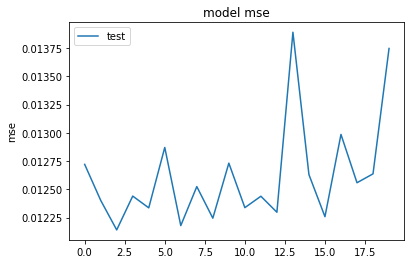

In [597]:
plt.plot(history.history['val_mse'])
plt.title('model mse')
plt.ylabel('mse')
plt.legend(['test'], loc='upper left')
plt.show()

In [598]:
for layer in model.layers:
    weights = layer.get_weights()
    print(len(weights[0]))

28
28


In [600]:
(model.layers[1].get_weights()[0])

array([[ 0.29888663],
       [ 0.10999739],
       [ 0.37830165],
       [-0.19726396],
       [ 0.07624647],
       [-0.19216777],
       [-0.1753181 ],
       [ 0.18845223],
       [-0.2552975 ],
       [ 0.22020008],
       [-0.27165374],
       [-0.32662755],
       [-0.5526944 ],
       [-0.23350012],
       [ 0.11874352],
       [ 0.3959702 ],
       [ 0.5271638 ],
       [-0.36426714],
       [-0.61447775],
       [ 0.22995527],
       [ 0.02458555],
       [-0.27060577],
       [-0.00490257],
       [-0.44255418],
       [-0.1520672 ],
       [-0.23767951],
       [-0.26996785],
       [-0.17031132]], dtype=float32)

In [601]:
X.sample()

,Numero,NbPieces,lon,lat,score_commerce,score_commerce_lux,periode_construction,Arrondissement,Quartier,score_jardin,score_monument,score_metro,TypeVoie_0,TypeVoie_1,TypeVoie_2,TypeVoie_3,TypeVoie_4,TypeVoie_5,TypeVoie_6,TypeVoie_7,TypeVoie_8,TypeVoie_9,TypeVoie_10,TypeVoie_11,TypeVoie_12,TypeVoie_13,TypeVoie_14,TypeVoie_15
8945,0.039409,0.05,0.390531,0.17547,0.160377,0.066667,0.272727,0.684211,0.696203,0.001469,0.157895,0.086769,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
